<a href="https://colab.research.google.com/github/Suvoo/Daad-Wise-prep/blob/main/JaxQuickstart_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import jax.numpy as jnp

from jax import grad, jit, vmap

from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

1. Numpy syntax is similar to JAX

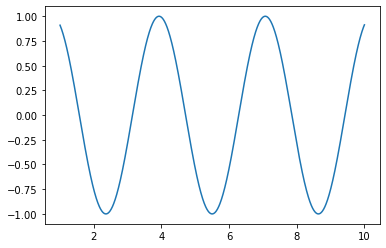

In [ ]:
# Numpy Syntax
x_np = np.linspace(1,10,1000) # start,stop,points 1000 point from 0-10 equally spaced
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np,y_np)

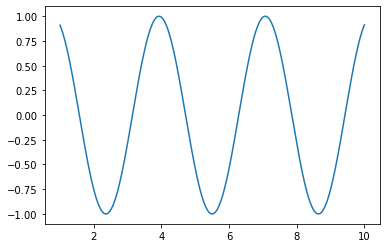

In [ ]:
# JAX Syntax
x_jnp = jnp.linspace(1,10,1000) # start,stop,points 1000 point from 0-10 equally spaced
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp,y_jnp)

2. JAX arrays are immutable(functional), but numpy arrays are mutable

In [ ]:
arr = [1,2,3,4,5,6,7,8,9,10]

# Numpy mutable
arr_np = np.array(arr)
print(arr_np)

arr_np[0] = 69
print(arr_np)

[ 1  2  3  4  5  6  7  8  9 10]
[69  2  3  4  5  6  7  8  9 10]


In [ ]:
# JAX immutable
arr_jnp = jnp.array(arr)
print(arr_jnp)

# arr_jnp[0] = 69
# print(arr_jnp)

# SOLUTION IS
brr_jnp = arr_jnp.at[0].set(69) # separate object is created, not directly
print(arr_jnp)
print(brr_jnp)

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[69  2  3  4  5  6  7  8  9 10]


3. Random Numbers are handled differently

In [15]:
# Numpy handles in a stateful manner, but jax is stateless

#key means state
seed  = 0
key =  random.PRNGKey(seed)

x = random.normal(key, (10, ))  # you need to explicitly pass the key i.e. PRNG state
print(type(x), x)  # notice the DeviceArray type - means no need to do to.cuda like in PYTORCH

<class 'jaxlib.xla_extension.DeviceArray'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


4. JAX is AI accelerator agnostic. Same code runs everywhere! (Numpy is only for CPU Programming, but jax tpu/gpu)

In [ ]:
size = 3000

# Data is automagically pushed to the AI accelerator! (DeviceArray structure)
# No more need for ".to(device)" (PyTorch syntax)
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note1: I'm using GPU as a synonym for AI accelerator. 
# In reality, especially in Colab, this can also be a TPU, etc.

# Note2: block_until_ready() -> asynchronous dispatch
# without this, work is delegated to accelerator 

The slowest run took 204.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 12.9 ms per loop
1 loop, best of 5: 683 ms per loop
The slowest run took 4.07 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 5: 44.4 ms per loop
100 loops, best of 5: 15 ms per loop


## JAX transform functions

1. JIT() --> compiles using XLA so it caches functions, so fast

In [ ]:
 # simple visualizer
def visualize(fn, l = -10, r = 10, n = 1000):
    x =  np.linspace(l,r,num=n)
    y = fn(x)
    plt.plot(x,y)
    plt.show()

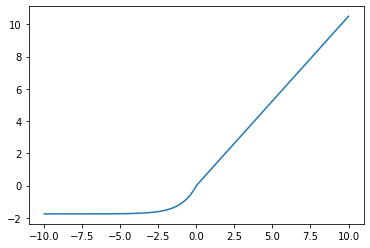

non-jit version:
The slowest run took 349.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.23 ms per loop
jit version:
The slowest run took 1976.93 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 145 µs per loop


In [ ]:
# define a sample function
# Scaled Exponential Linear Unit (SELU) activation function
def selu(x, alpha=1.67, lmbda=1.05):  # note: SELU is an activation function
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu) # using JIT on the activation func

visualize(selu) # print graph of the SELU Activation fun

# Benchmark non-jit vs jit version
data = random.normal(key, (1000000,))

print('non-jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

# Note: we'll soon see how this works (hint: jaxpr, pure functions)


In [ ]:
# just to see output
# Benchmark non-jit vs jit version
data = random.normal(key, (1000000,))
data

DeviceArray([ 1.99376   ,  0.20781846, -0.34406224, ...,  0.03467206,
              0.7103182 ,  0.1965587 ], dtype=float32)

2. GRAD() --> for differntiation (TypeError: grad requires real- or complex-valued inputs

- manual
- symbolic
- numeric
- automatic (used in jax/pytorch)


In [ ]:
# define a function (earlier sigmoid) or sum
def sum_logistic(x):
    return jnp.sum(x**2) # 2x is derivative

x = jnp.arange(3.) # same as --> jnp.array([0,1,2])
print(x)
ans = sum_logistic(x)
print(ans) # 0 + 1 + 4
grad_loss =  grad(sum_logistic)
grad_loss(x)

[0. 1. 2.]
5.0


DeviceArray([0., 2., 4.], dtype=float32)

In [ ]:
x = jnp.arange(3)

In [ ]:
ans = sum_logistic(jnp.array([0,1,2]))
ans

DeviceArray(5, dtype=int32)

In [ ]:
# First example (automatic diff)

def sum_logistic(x):  # or maybe a simpler example: sum of squares? (jnp.sum(x**2))
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic  # rename it to give it some semantics

# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
# Here we bundled inputs into a 1st param so it doesn't matter.
grad_loss = grad(loss)

print(grad_loss(x))

[0.25       0.19661194 0.10499357]


In [ ]:
# Numeric diff (to double check that autodiff works correctly)

def finite_differences(f, x):
    eps = 1e-3

    # (f(0+e, 1, 2) - f(0-e, 1, 2) )/ 2e
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)  # derivative definition
                                for v in jnp.eye(len(x))])

print(finite_differences(sum_logistic, x))

[0.        1.9998549 3.9999483]


In [ ]:
jnp.eye(len(x)) # this is identity matrix

DeviceArray([[1., 0., 0.],
             [0., 1., 0.],
             [0., 0., 1.]], dtype=float32)

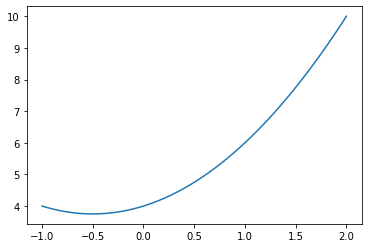

6.0 3.0 2.0 0.0


In [ ]:
# Second example(automatic diff)

x = 1.
f = lambda x: x ** 2 + x + 4
visualize(f, l=-1, r=2, n=100)

dfdx = grad(f) # 2*x + 1
d2fdx = grad(dfdx) # 2
d3fdx = grad(d2fdx) # 0

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

In [ ]:
# same as lambda func
def f1(x):
    return x**2 + x + 4
f1(x)

6.0

In [ ]:
# for 2 variables (x,y) --> by default it is differentiated by x. To change we need to set argnums = 1
x = 1.
y = 1.
f = lambda x,y: x ** 2 + x + 4 + y**2

dfdx = grad(f,argnums=(1)) # diff wrt y
print(f(x,y),dfdx(x,y))

7.0 2.0


Deriatives of vector valued func --> Jacobian

In [ ]:
 # JAX autodiff engine is very powerful ("advanced" example)

from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2  # simple paraboloid (google it...)

# df/dx = 2x
# df/dy = 2y
# Jacobian = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# Hessian = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]] #matrix which is collection

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True))
Full Hessian = ((DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(0., dtype=float32, weak_type=True)), (DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True)))


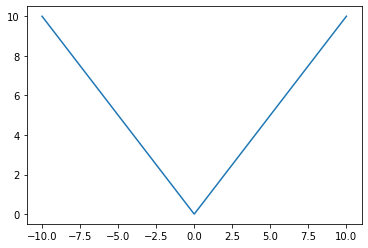

1 1
1.0 -1.0


In [ ]:
# edge case
def edge(x):
    return abs(x)
visualize(edge)

print(edge(-1),edge(1))

dfdx = grad(edge)
print(dfdx(0.),dfdx(-1.)) 
# grad is undefined at 0
# convention is +ve value

3.VMAP() --> write functions as if we are dealing with a single datapoint
- removes  for loop, does all at once



In [ ]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1) # only for a single image, not a batch

In [ ]:
# iterate through all
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready

Naively batched
The slowest run took 86.90 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 3.12 ms per loop


In [ ]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
The slowest run took 623.84 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 93.9 µs per loop


In [ ]:
@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
The slowest run took 299.84 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 43.4 µs per loop


## JAX API Structure

Like an Onion Structure

- NumPy <-> lax <-> XLA (1,2,3)
- lax API is stricter and more powerful
- It's a Python wrapper around XLA

In [5]:
# Example 1 :LAX is stricter

print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
# print(lax.add(1, 1.0))  # jax.lax API requires explicit type promotion
print(lax.add(1, 1)) # Only same types

2.0
2


In [13]:
# Example 2: lax is more powerful (but as a tradeoff less user-friendly)

x = jnp.array([1, 2, 1])
y = jnp.ones(10)

# NumPy API
result1 = jnp.convolve(x, y)

# lax API
# -- > return batched result
result2 = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy

print(result1)
print(result2[0][0])
assert np.allclose(result1, result2[0][0], atol=1E-6)

# AS LAX is a wrapper around XLA, so XLA function called is ConvWithGeneralPadding

# XLA: https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution

[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]
[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]


How does JIT Actually work?

In [16]:
# Why JIT? -> jitted functions are much faster.

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

assert np.allclose(norm(X), norm_compiled(X), atol=1E-6)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

1000 loops, best of 5: 765 µs per loop
1000 loops, best of 5: 619 µs per loop


In [18]:
# Example of a failure: array shapes must be static

def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))

[-0.3721109  -0.18252768 -0.7368197  -0.44030377 -0.1521442  -0.67135346
 -0.5908641 ]


In [20]:
get_neg_jit = jit(get_negatives)
# get_neg_jit(x) # ERROR
# depending on value of x, who varies in shape...so thats not allowed

In [21]:
# So how does it work in the background? -> tracing on different levels of abstraction
# Caching mechanism..so same shapes-->always call the complied func
@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print('Second call:')
print(f(x2, y2))  # Oops! Side effects (like print) are not compiled...

# Note: any time we get the same shapes and types we just call the compiled fn!

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>
[4.206792  3.3897438 1.7549036]
Second call:
[4.403898 2.987666 4.219093]


In [23]:
# Same function as above just without the print statements
def f(x, y):
    return jnp.dot(x + 1, y + 1)

print(make_jaxpr(f)(x, y))
# jax expression -->jaxpr

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(((1,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] c d
  in (e,) }


In [24]:
# 2nd example of a failure:

@jit
def f(x, neg):  # depends on the value - remember tracer cares about shapes and types!
    return -x if neg else x

f(1, True)

ConcretizationTypeError: ignored

In [25]:
# Workaround: the "static" arguments

from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

print(f(1, True))
print(f(2, True))
print(f(2, False))
print(f(23, False))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
2
23


In [27]:
# 3rd example of a failure:

# Task: add some print statements! (<expanding mind>)

@jit
def f(x):
    print(x)
    print(x.shape)
    print(jnp.array(x.shape).prod())
    return x.reshape(jnp.array(x.shape).prod()) # reshape expects concrete value. not traced

x = jnp.ones((2, 3))
f(x)

Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=0/1)>
(2, 3)
Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>


TypeError: ignored

In [29]:
# Workaround: using numpy instead of jax.numpy

@jit
def f(x):
    print(x)
    print(x.shape)
    print(np.array(x.shape).prod())
    return x.reshape((np.prod(x.shape),))

f(x)

Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=0/1)>
(2, 3)
6


DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32)

## JAX Idiosyncrasies

### Gotcha #1: Pure functions
JAX is designed to work only on pure functions!
Pure function? Informal definition:

- All the input data is passed through the function parameters, all the results 
are output through the function results.
- A pure function will always return the same result if invoked with the same inputs.

In [30]:
 # Example 1

def impure_print_side_effect(x):
    print("Executing function")  # Violating #1
    return x

# The side-effects appear during the first run 
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compiled version of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))

Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [5.]


In [31]:
# Example 2

g = 0.

def impure_uses_globals(x):
    return x + g  # Violating both #1 and #2

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global!
g = 10.

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))

First call:  4.0
Second call:  5.0
Third call, different type:  [14.]


In [32]:
# Example 3: very important! Haiku/Flax are basically built upon this idea!
# states --> correct execution
def pure_uses_internal_state(x):

    state = dict(even=0, odd=0)
    for i in range(10):
        state['even' if i % 2 == 0 else 'odd'] += x

    return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(5.))

50.0


In [33]:
# Example 4: iterators are a no no!

# lax.fori_loop; similarly for lax.scan, lax.cond, etc.
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0))  # expected result 45

iterator = iter(range(10)) # cant as they are statefull
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0))  # unexpected result 0

45
0


### Gotcha #2: In-Place Updates

add set, immutable

In [34]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)
updated_array = jax_array.at[1, :].set(1.0)

print("original array unchanged:\n", jax_array)
print("updated array:\n", updated_array)

# If this seems wasteful to you, congrats, you did some algorithms/data structures in your life. ;)
# The thing is - inside jit-compiled code, if the input value x of x.at[idx].set(y) 
# is not reused, the compiler will optimize the array update to occur in-place!

original array unchanged:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [35]:
# The expresiveness of NumPy is still there!

print("original array:")
jax_array = jnp.ones((5, 6))
print(jax_array)

print("new array post-addition:")
new_jax_array = jax_array.at[::2, 3:].add(7.) # not only set, other ops as well
print(new_jax_array)

original array:
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
new array post-addition:
[[1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]]


### Gotcha #3: Out-of-Bounds Indexing
Due to JAX's accelerator agnostic approach JAX had to make a non-error behaviour for out of bounds indexing (similarly to how invalid fp arithmetic results in NaNs and not an exception).

In [36]:
# NumPy behavior

try:
  np.arange(10)[11]
except Exception as e:
    print("Exception {}".format(e))

Exception index 11 is out of bounds for axis 0 with size 10


In [37]:
# JAX behavior
# 1) updates at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(10).at[11].add(23))  # example of 1) # no change
print(jnp.arange(10)[11])  # example of 2) -->make 11 to 10th index...so bad bugs

[0 1 2 3 4 5 6 7 8 9]
9


## Gotcha #4: Non-array inputs
This is added by design (performance reasons)

In [38]:
# NumPy
print(np.sum([1, 2, 3])) #python list works

6


In [40]:
# JAX

try:
    jnp.sum([1, 2, 3]) # python doesnt work
except TypeError as e:
    print(f"TypeError: {e}")

TypeError: sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


In [41]:
# Why? jaxpr to the rescue!
# bad
def permissive_sum(x):
    return jnp.sum(jnp.array(x))

x = list(range(10))
print(make_jaxpr(permissive_sum)(x))

{ lambda ; a:i32[] b:i32[] c:i32[] d:i32[] e:i32[] f:i32[] g:i32[] h:i32[] i:i32[]
    j:i32[]. let
    k:i32[] = convert_element_type[new_dtype=int32 weak_type=False] a
    l:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] c
    n:i32[] = convert_element_type[new_dtype=int32 weak_type=False] d
    o:i32[] = convert_element_type[new_dtype=int32 weak_type=False] e
    p:i32[] = convert_element_type[new_dtype=int32 weak_type=False] f
    q:i32[] = convert_element_type[new_dtype=int32 weak_type=False] g
    r:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
    s:i32[] = convert_element_type[new_dtype=int32 weak_type=False] i
    t:i32[] = convert_element_type[new_dtype=int32 weak_type=False] j
    u:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] k
    v:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] l
    w:i32[1] = broadcast_in_dim[broadcast_dimensions=() shap

### Gotcha #5: random numbers

In [42]:
# NumPy - PRNG is stateful!

# Let's sample calling the same function twice
print(np.random.random())
print(np.random.random())

np.random.seed(seed)

rng_state = np.random.get_state()
print(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

# statefull -->bad, not pure
# Mersenne Twister PRNG is known to have a number of problems (NumPy's imp of PRNG)

0.12999035459744346
0.04142664260876727
(624, 0, 0.0)
(2, 0, 0.0)
(4, 0, 0.0)


In [43]:
# JAX's random functions can't modify PRNG's state!

key = random.PRNGKey(seed)
print(key)  # key defines the state (2 unsigned int32s)

# Let's again sample calling the same function twice
print(random.normal(key, shape=(1,)))
print(key)  # verify that the state hasn't changed

print(random.normal(key, shape=(1,)))  # oops - same results? -->not modified the state, so state is preserved
print(key)

[0 0]
[-0.20584226]
[0 0]
[-0.20584226]
[0 0]


In [44]:
# Solution? -> Split every time you need a pseudorandom number.

print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

# Note1: you can also split into more subkeys and not just 1
# Note2: key, subkey no difference it's only a convention

old key [0 0]
    \---SPLIT --> new key    [4146024105  967050713]
             \--> new subkey [2718843009 1272950319] --> normal [-1.2515389]


In [47]:
# Why this design? 
# Well...think...with current design can the code be:
# 1) reproducible? (numpy obeys)
# 2) parallelizable? (NO)
# 3) vectorisable?

np.random.seed(seed)

def bar(): return np.random.uniform()
def baz(): return np.random.uniform()

# e.g. bar=0.3 baz=0.4 [0.3 + 2*0.4] [0.4 + 2*0.3] -> not reproducible in parallel envs!
def foo(): return bar() + 2 * baz()

print(foo())

# What if we want to parallelize this code? NumPy assumes too much. 2) is violated.

1.9791922366721637


In [48]:
# NumPy
np.random.seed(seed)
print("individually:", np.stack([np.random.uniform() for _ in range(3)]))

np.random.seed(seed)
print("all at once: ", np.random.uniform(size=3))

# JAX
key = random.PRNGKey(seed)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(seed)
print("all at once: ", random.normal(key, shape=(3,)))

# NumPy violates 3)

individually: [0.5488135  0.71518937 0.60276338]
all at once:  [0.5488135  0.71518937 0.60276338]
individually: [1.1188384 0.5781488 0.8535516]
all at once:  [ 1.8160863  -0.48262316  0.33988908]


allows same randomneess (jit) which numpy doesnt allow.

### Gotcha #6: Control Flow

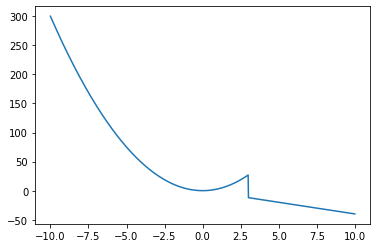

12.0
-4.0


In [49]:
# Python control flow + grad() -> everything is ok
def f(x):
    if x < 3:
        return 3. * x ** 2
    else:
        return -4 * x

x = np.linspace(-10, 10, 1000)
y = [f(el) for el in x]
plt.plot(x, y); plt.show()

print(grad(f)(2.))  # ok!
print(grad(f)(4.))  # ok!

In [50]:

# Python control flow + jit() -> problems in paradise.

# "The tradeoff is that with higher levels of abstraction we gain a more general view
# of the Python code (and thus save on re-compilations), 
# but we require more constraints on the Python code to complete the trace."

# Example 1: conditioning on value (same function as in the above cell)
# Solution (recall: we already have seen this)
f_jit = jit(f, static_argnums=(0,))
x = 2.

print(make_jaxpr(f_jit, static_argnums=(0,))(x))
print(f_jit(x))

{ lambda ; . let
    a:f32[] = xla_call[call_jaxpr={ lambda ; . let  in (12.0,) } name=f] 
  in (a,) }
12.0


In [51]:
# Example 2: range depends on value again

def f(x, n):
    y = 0.
    for i in range(n):
        y = y + x[i]
    return y

f_jit = jit(f, static_argnums=(1,))
x = (jnp.array([2., 3., 4.]), 15)

print(make_jaxpr(f_jit, static_argnums=(1,))(*x))  # notice how for loop gets unrolled
print(f_jit(*x))

# Note: there is a catch - static args should not change a lot!

{ lambda ; a:f32[3]. let
    b:f32[] = xla_call[
      call_jaxpr={ lambda ; c:f32[3]. let
          d:bool[] = lt 0 0
          e:i32[] = add 0 3
          f:i32[] = select_n d 0 e
          g:i32[] = convert_element_type[new_dtype=int32 weak_type=False] f
          h:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] g
          i:f32[] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), start_index_map=(0,))
            fill_value=None
            indices_are_sorted=True
            mode=GatherScatterMode.PROMISE_IN_BOUNDS
            slice_sizes=(1,)
            unique_indices=True
          ] c h
          j:f32[] = add i 0.0
          k:bool[] = lt 1 0
          l:i32[] = add 1 3
          m:i32[] = select_n k 1 l
          n:i32[] = convert_element_type[new_dtype=int32 weak_type=False] m
          o:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] n
          p:f32[] = gather[
            dimension_num

In [52]:
# Even "better" (it's less readable) solution is to use low level API
def f_fori(x, n):
    body_fun = lambda i,val: val+x[i]
    return lax.fori_loop(0, n, body_fun, 0.)

f_fori_jit = jit(f_fori)

print(make_jaxpr(f_fori_jit)(*x))
print(f_fori_jit(*x))

{ lambda ; a:f32[3] b:i32[]. let
    c:f32[] = xla_call[
      call_jaxpr={ lambda ; d:f32[3] e:i32[]. let
          _:i32[] _:i32[] f:f32[] = while[
            body_jaxpr={ lambda ; g:f32[3] h:i32[] i:i32[] j:f32[]. let
                k:i32[] = add h 1
                l:bool[] = lt h 0
                m:i32[] = add h 3
                n:i32[] = select_n l h m
                o:i32[] = convert_element_type[new_dtype=int32 weak_type=False] n
                p:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] o
                q:f32[] = gather[
                  dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), start_index_map=(0,))
                  fill_value=None
                  indices_are_sorted=True
                  mode=GatherScatterMode.PROMISE_IN_BOUNDS
                  slice_sizes=(1,)
                  unique_indices=True
                ] g p
                r:f32[] = convert_element_type[
                  new_dtype=float32

In [53]:
# Example 3: this is not problematic (it'll only cache a single branch)

def log2_if_rank_2(x):
    if x.ndim == 2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2.0)
        return ln_x / ln_2
    else:
        return x

print(make_jaxpr(log2_if_rank_2)(jnp.array([1, 2, 3])))

{ lambda ; a:i32[3]. let  in (a,) }


### Gotcha #7: NaNs

In [55]:
jnp.divide(0., 0.)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: ignored

In [56]:
jnp.divide(0., 0.)  # the default non-error behavior will simply return a NaN (as usually)

# If you want to debug where the NaNs are coming from, there are multiple ways
# to do that, here is one:
# from jax.config import config
# config.update("jax_debug_nans", True)

import jax.config
jax.config.update('jax_enable_x64', True)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: ignored

In [57]:
# JAX enforces single precision! There are simple ways around it though.

x = random.uniform(key, (1000,), dtype=jnp.float64)
print(x.dtype)

float32


In [60]:
y = random.uniform(key, (1000,))
print(y.dtype)

float32
